In [1]:
import numpy as np
import pylab as plt
%matplotlib inline
import tqdm, json

In [2]:
import sys
sys.path.append('../../')
from frb_periodicity.search import pr3_search, riptide_search, p4j_search
from frb_periodicity.utils import get_phase

In [3]:
with open('r3_data.json', 'r') as f:
    r3_data = json.load(f)

In [4]:
burst_dict = r3_data['bursts']
startmjds_dict = r3_data['obs_startmjds']
duration_dict = r3_data['obs_duration']

In [5]:
r3_data.keys()

dict_keys(['bursts', 'obs_duration', 'obs_startmjds', 'sensitivity'])

In [6]:
startmjds_dict.keys()

dict_keys(['CHIME', 'DSN_L', 'DSN_S', 'DSN_X', 'Effelsberg', 'GBT300', 'LOFAR', 'NC', 'SRT_L', 'SRT_P', 'VLA'])

# Let's do periodicity searches using all published bursts of R3

In [7]:
bursts = []
for k in burst_dict.keys():
    bursts += burst_dict[k]
bursts = np.array(bursts)

In [8]:
# bursts = np.sort(bursts - np.min(bursts))
unique_days = np.unique(np.round(bursts))

In [9]:
startmjds = []
for k in startmjds_dict.keys():
    startmjds += startmjds_dict[k]
startmjds = np.array(startmjds)

In [10]:
durations = []
for k in duration_dict.keys():
    durations += duration_dict[k]
durations = np.array(durations)

## Pearson chi-square test (PR3)

### Actually, this method should not be used on this dataset, as it requires a uniform phase coverage, which is clearly not the case here, look at the Fig 1. (phase plot) in the research note. But, let's still do it. 

In [11]:
rch, p = pr3_search(bursts=bursts, obs_mjds=startmjds, 
                    obs_durations=durations)

  1%|          | 2308/358448 [00:01<03:51, 1537.37it/s]../../frb_periodicity/utils.py:35: RuntimeWarning: invalid value encountered in true_divide
  return (((N - E)**2)/E).sum()
100%|██████████| 358448/358448 [02:44<00:00, 2174.81it/s]
2020-06-03 14:40:50,094 - pr3_search -root - INFO - Max reduced chi square value is 23.99710520904576 at period of 1.8803803630662275


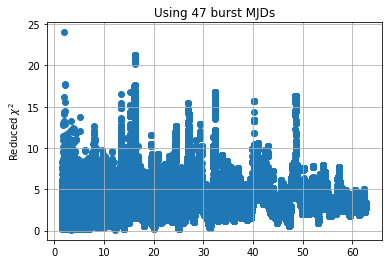

In [12]:
plt.scatter(p, rch)
plt.ylabel(r'Reduced $\chi^2$')
plt.title(f'Using {len(bursts)} burst MJDs')
plt.grid()

### Looks like there is a peak around 16 day period. But there is a stronger peak at 1.88 days. This is probably an alias due to daily CHIME observations.  
#### Let's try just with the activity days

In [13]:
rch_uniq, p = pr3_search(bursts=unique_days, obs_mjds=startmjds, 
                    obs_durations=durations)

  1%|          | 2291/358807 [00:01<02:51, 2084.30it/s]../../frb_periodicity/utils.py:35: RuntimeWarning: divide by zero encountered in true_divide
  return (((N - E)**2)/E).sum()
100%|██████████| 358807/358807 [02:41<00:00, 2226.28it/s]
2020-06-03 14:43:34,907 - pr3_search -root - INFO - Max reduced chi square value is 80.81730508687751 at period of 1.9932103142087925


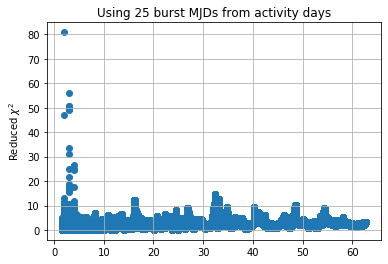

In [14]:
plt.scatter(p, rch_uniq)
plt.ylabel(r'Reduced $\chi^2$')
plt.title(f'Using {len(unique_days)} burst MJDs from activity days')
plt.grid()

### The peak at 16 day period got weaker, and the one at the alias of sidereal day got stronger. Well, this method wasn't gonna work anyway on this non uniformly covered dataset. 

# Searching for period with narrowest folded profile (Rajwade et al 2020)
### Rajwade et al (2020) actually call it searching for the largest continuous fraction in the folded profile without burst signal

In [28]:
bursts = np.sort(bursts - np.min(bursts))
unique_days = np.unique(np.round(bursts))

In [29]:
cont_frac, p = riptide_search(bursts, pmin=24*60*60, pmax=50*(24*60*60))

2020-06-03 14:49:50,874 - riptide_search -root - WARNING - Period/nbins should be greater than tsamp. Not all periods in the given range are valid. Selecting the valid periods for search.
100%|██████████| 3542/3542 [00:03<00:00, 1128.47it/s]
2020-06-03 14:49:54,017 - riptide_search -root - INFO - Max continuous fraction without data is 0.725 at a period of 16.267716535433074 days


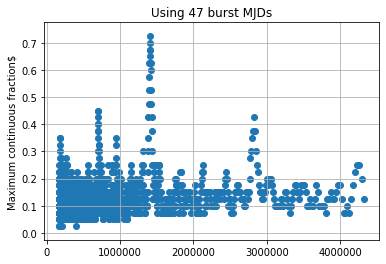

In [30]:
plt.scatter(p, cont_frac)
plt.ylabel(r'Maximum continuous fraction$')
plt.title(f'Using {len(bursts)} burst MJDs')
plt.grid()

#### This was quick. :) <br>  As has been noted in the log and can be seen in the plot, strongest peak occurs at 16.26 day period, which is consistent with PR3. <br> Let's just use the unique days now


In [24]:
cont_frac_uniq, p = riptide_search(unique_days, pmin=24*60*60, pmax=50*(24*60*60))

2020-06-03 14:43:52,382 - riptide_search -root - WARNING - Period/nbins should be greater than tsamp. Not all periods in the given range are valid. Selecting the valid periods for search.
100%|██████████| 3545/3545 [00:03<00:00, 1140.32it/s]
2020-06-03 14:43:55,494 - riptide_search -root - INFO - Max continuous fraction without data is 0.725 at a period of 16.275303643724698 days


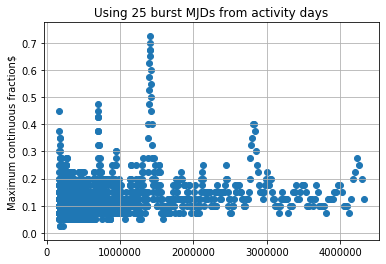

In [25]:
plt.scatter(p, cont_frac_uniq)
plt.ylabel(r'Maximum continuous fraction$')
plt.title(f'Using {len(unique_days)} burst MJDs from activity days')
plt.grid()

#### Again we get a peak at 16.27 day, consistent with PR3. All good. 

# Using P4J
### using QMI based on Euclidean distance for periodogram. See https://github.com/phuijse/P4J

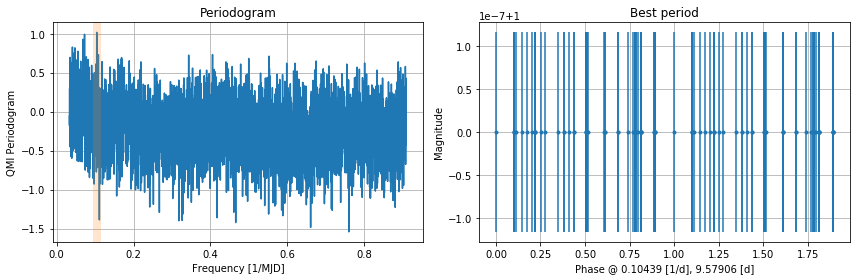

In [26]:
periodogram, p = p4j_search(bursts, pmin=1.1, pmax=30, plot=True, save=False)

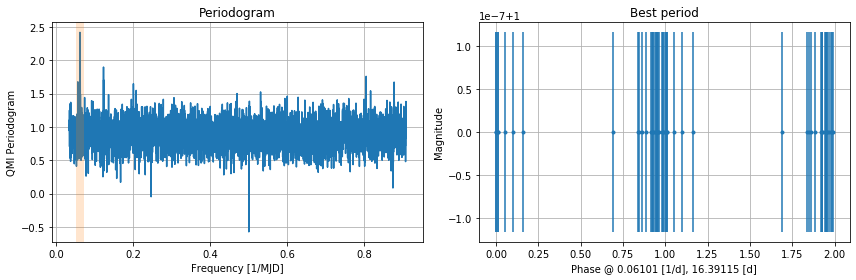

In [27]:
periodogram_unique, p = p4j_search(unique_days, pmin=1.1, pmax=30, plot=True, save=False)